In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from pymongo import MongoClient

In [3]:
!pip install pymongo

In [9]:
client = MongoClient('mongodb://localhost:27017/', username='root', password='rootpwd', timeoutMS=60000)

if client:
    print("connected to mongo database successully.")
else:
    print("failed to connect to mongo database.")

connected to mongo database successully.


In [11]:
db = client['imdb']
collection = db['movies']
collection.delete_many({})

DeleteResult({'n': 0, 'ok': 1.0}, acknowledged=True)

In [13]:
url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/?ref_=bo_cso_ac"
headers = {'User-Agent': 'Mozilla/5.0'}

In [15]:
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

In [17]:
print(soup.prettify())

<!DOCTYPE html>
<html class="a-no-js" data-19ax5a9jf="dingo">
 <head>
  <script>
   var aPageStart = (new Date()).getTime();
  </script>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   var ue_t0=ue_t0||+new Date();
  </script>
  <script type="text/javascript">
   window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);


    var ue_err_chan = 'jserr-rw';
(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b

In [19]:
movies = []

rows = soup.select("table.mojo-body-table tr")[1:]

for row in rows:
    cols = row.find_all("td")
    if len(cols) >= 4:
        rank = int(cols[0].text.strip())
        title = cols[1].text.strip()
        gross = cols[2].text.strip().replace("$", "").replace(",", "")
        year = cols[3].text.strip()

        movies.append({
            "rank": rank,
            "title": title,
            "lifetime_gross": int(gross),
            "year": int(year)
        })

In [21]:
movies

[{'rank': 1,
  'title': 'Star Wars: Episode VII - The Force Awakens',
  'lifetime_gross': 936662225,
  'year': 2015},
 {'rank': 2,
  'title': 'Avengers: Endgame',
  'lifetime_gross': 858373000,
  'year': 2019},
 {'rank': 3,
  'title': 'Spider-Man: No Way Home',
  'lifetime_gross': 814866759,
  'year': 2021},
 {'rank': 4, 'title': 'Avatar', 'lifetime_gross': 785221649, 'year': 2009},
 {'rank': 5,
  'title': 'Top Gun: Maverick',
  'lifetime_gross': 718732821,
  'year': 2022},
 {'rank': 6,
  'title': 'Black Panther',
  'lifetime_gross': 700426566,
  'year': 2018},
 {'rank': 7,
  'title': 'Avatar: The Way of Water',
  'lifetime_gross': 684075767,
  'year': 2022},
 {'rank': 8,
  'title': 'Avengers: Infinity War',
  'lifetime_gross': 678815482,
  'year': 2018},
 {'rank': 9, 'title': 'Titanic', 'lifetime_gross': 674354882, 'year': 1997},
 {'rank': 10,
  'title': 'Jurassic World',
  'lifetime_gross': 653406625,
  'year': 2015},
 {'rank': 11,
  'title': 'Inside Out 2',
  'lifetime_gross': 65298

In [23]:
list_movies = list(movies)
df_movies = pd.DataFrame(list_movies)

df_movies.shape

(200, 4)

In [ ]:
df_movies.to_json("df_movies.json", orient = "records")

In [25]:
collection = db['collection']

In [27]:
try:
    with open(r"df_movies.json") as f1:
        df = json.load(f1)
        collection.insert_many(df)

    print("Inserted data")
except FileNotFoundError:
    print("File not found. Please check the file path.")

Inserted data


In [29]:
collection.delete_many({})
collection.insert_many(movies)
print(f"Inserted {len(movies)} records into MongoDB")

Inserted 200 records into MongoDB


In [31]:
collection.count_documents({})

200

# Part 3

### Top 10 Grossing Movies
Purpose: Identify the top 10 movies with the highest lifetime gross.


In [33]:
top_10 = collection.find(
    {},
    {"_id": 0, "title": 1, "lifetime_gross": 1}
).sort("lifetime_gross", -1).limit(10)

df_top_10 = pd.DataFrame(list(top_10))
df_top_10


,title,lifetime_gross
0,Star Wars: Episode VII - The Force Awakens,936662225
1,Avengers: Endgame,858373000
2,Spider-Man: No Way Home,814866759
3,Avatar,785221649
4,Top Gun: Maverick,718732821
5,Black Panther,700426566
6,Avatar: The Way of Water,684075767
7,Avengers: Infinity War,678815482
8,Titanic,674354882
9,Jurassic World,653406625


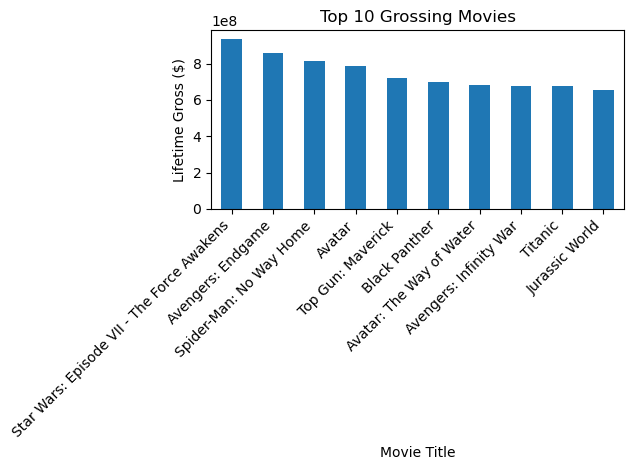

In [35]:
import matplotlib.pyplot as plt

df_top_10.plot(kind='bar', x='title', y='lifetime_gross', legend=False)
plt.ylabel('Lifetime Gross ($)')
plt.xlabel('Movie Title')
plt.title('Top 10 Grossing Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Gross Revenue by Decade
Purpose: Show how total box office revenue trends change over decades.

In [40]:
pipeline = [
    {"$addFields": {
        "decade": {"$subtract": ["$year", {"$mod": ["$year", 10]}]}
    }},
    {"$group": {
        "_id": "$decade",
        "total_gross": {"$sum": "$lifetime_gross"}
    }},
    {"$sort": {"_id": 1}}
]

df_by_decade = pd.DataFrame(list(collection.aggregate(pipeline))).rename(columns={"_id": "decade"})
df_by_decade

,decade,total_gross
0,1970,961267776
1,1980,2026744860
2,1990,4619869308
3,2000,16671138041
4,2010,33549557526
5,2020,12298458730


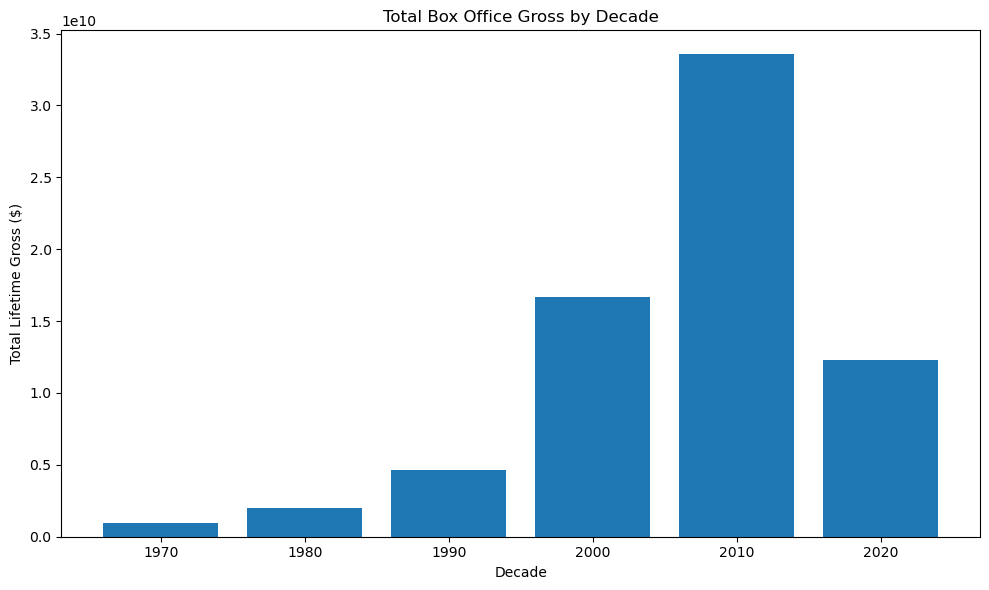

In [42]:
plt.figure(figsize=(10, 6))
plt.bar(df_by_decade["decade"].astype(str), df_by_decade["total_gross"])
plt.xlabel("Decade")
plt.ylabel("Total Lifetime Gross ($)")
plt.title("Total Box Office Gross by Decade")
plt.tight_layout()
plt.show()

### Number of Movies Released per Decade
Purpose: Counts the number of movies released in each decade to examine industry production trends and assess how content volume has evolved over time.

In [59]:
pipeline_movie_count_per_decade = [
    {"$addFields": {
        "decade": {"$subtract": ["$year", {"$mod": ["$year", 10]}]}
    }},
    {"$group": {
        "_id": "$decade",
        "movie_count": {"$sum": 1}
    }},
    {"$sort": {"_id": 1}}
]


df_movies_per_decade = pd.DataFrame(list(collection.aggregate(pipeline_movie_count_per_decade))).rename(columns={"_id": "decade"})
df_movies_per_decade

,decade,movie_count
0,1970,3
1,1980,7
2,1990,14
3,2000,54
4,2010,93
5,2020,29


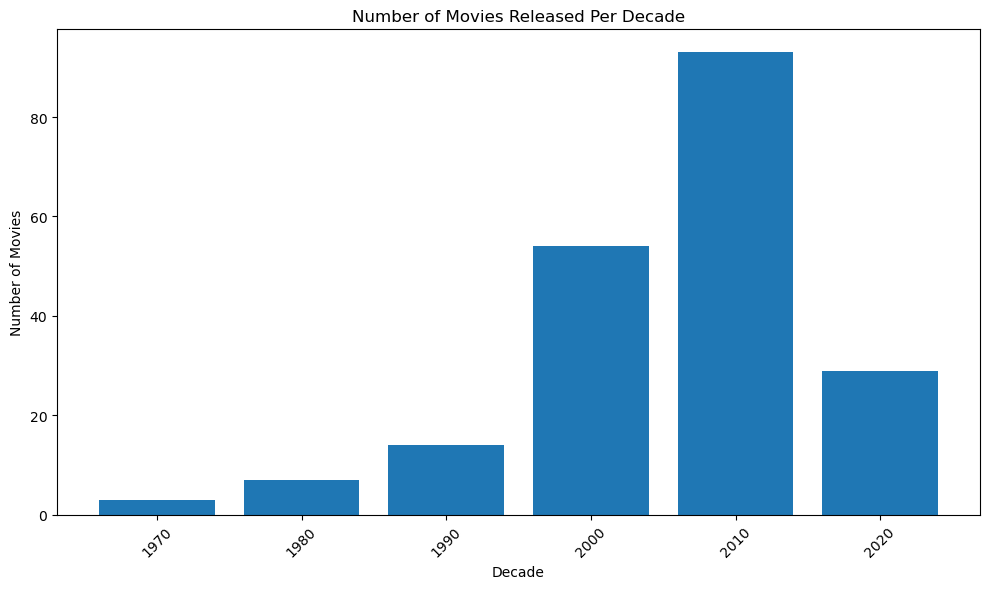

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(df_movies_per_decade['decade'].astype(str), df_movies_per_decade['movie_count'])
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released Per Decade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Movie Contribution to Annual Box Office Revenue
Purpose: Calculates each movie’s percentage contribution to its release year’s total box office revenue to identify the most dominant films annually.

In [63]:
pipeline_contribution_per_movie = [
    {
        "$group": {
            "_id": "$year",
            "total_year_gross": {"$sum": "$lifetime_gross"},
            "movies": {"$push": {"title": "$title", "gross": "$lifetime_gross"}}
        }
    },
    {"$unwind": "$movies"},
    {
        "$project": {
            "year": "$_id",
            "title": "$movies.title",
            "lifetime_gross": "$movies.gross",
            "contribution_pct": {
                "$multiply": [
                    {"$divide": ["$movies.gross", "$total_year_gross"]},
                    100
                ]
            }
        }
    },
    {"$sort": {"year": 1, "contribution_pct": -1}}
]
df_contribution_per_movie = pd.DataFrame(list(collection.aggregate(pipeline_contribution_per_movie)))
df_contribution_per_movie

,_id,year,title,lifetime_gross,contribution_pct
0,1973,1973,The Exorcist,233005644,100.000000
1,1975,1975,Jaws,267263625,100.000000
2,1977,1977,Star Wars: Episode IV - A New Hope,460998507,100.000000
3,1980,1980,Star Wars: Episode V - The Empire Strikes Back,292753960,100.000000
4,1981,1981,Raiders of the Lost Ark,248159971,100.000000
...,...,...,...,...,...
195,2024,2024,Mufasa: The Lion King,254567693,6.495637
196,2024,2024,Sonic the Hedgehog 3,236115100,6.024794
197,2025,2025,A Minecraft Movie,423579547,41.044274
198,2025,2025,Lilo & Stitch,335796345,32.538202


In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

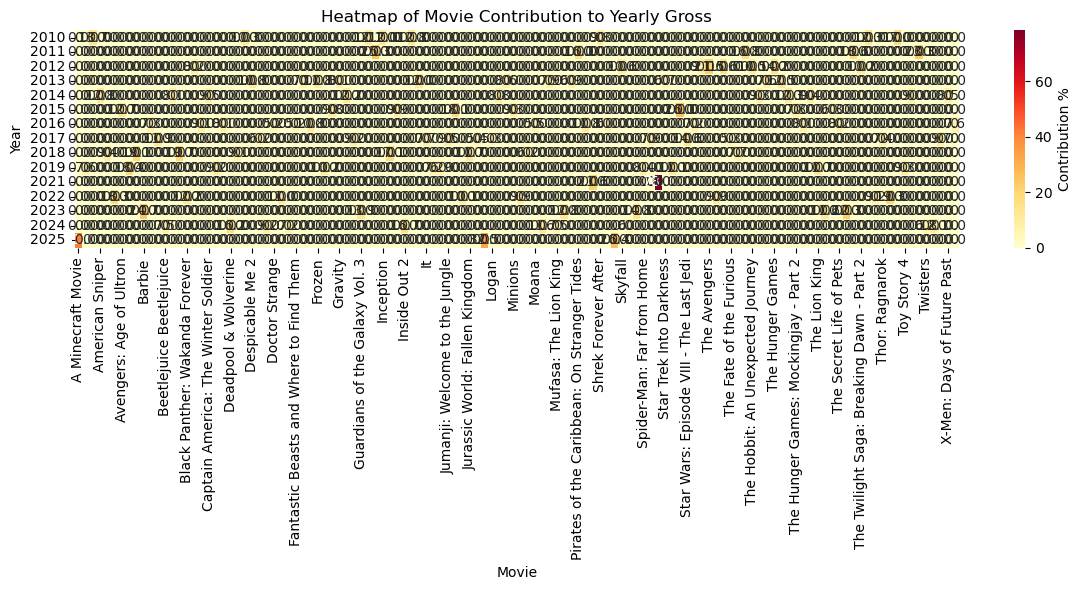

In [69]:
filtered = df_contribution_per_movie[df_contribution_per_movie["year"] >= 2010]

grouped = filtered.groupby(["year", "title"]).agg({
    "contribution_pct": "sum"
}).reset_index()

heatmap_df = grouped.pivot(index="year", columns="title", values="contribution_pct").fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Contribution %'})
plt.title("Heatmap of Movie Contribution to Yearly Gross")
plt.xlabel("Movie")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

### Average Gross per Decade

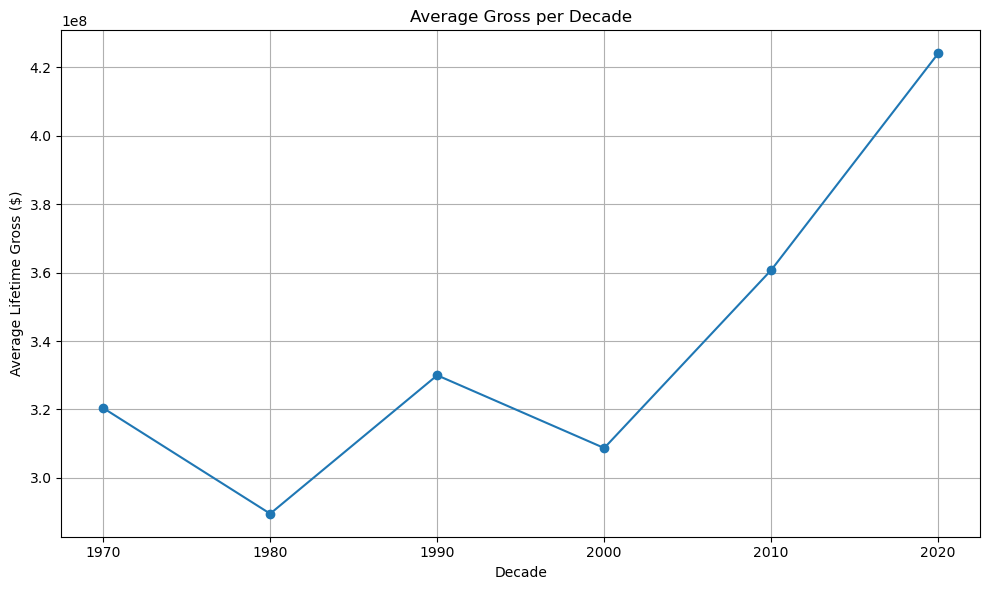

In [71]:
pipeline = [
    {"$project": {
        "decade": {"$subtract": ["$year", {"$mod": ["$year", 10]}]},
        "lifetime_gross": 1
    }},
    {"$group": {
        "_id": "$decade",
        "avg_gross": {"$avg": "$lifetime_gross"}
    }},
    {"$sort": {"_id": 1}}
]

results = list(collection.aggregate(pipeline))
df2 = pd.DataFrame(results)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(df2["_id"], df2["avg_gross"], marker='o')
plt.title("Average Gross per Decade")
plt.xlabel("Decade")
plt.ylabel("Average Lifetime Gross ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Top Grossing Movie vs All Others

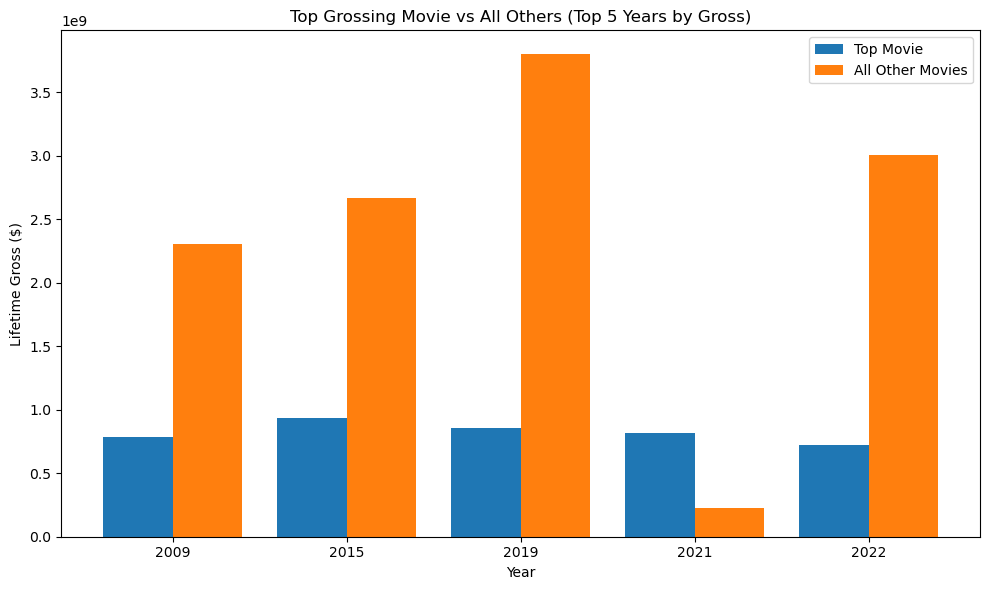

In [49]:
top5_movies = list(collection.find().sort("lifetime_gross", -1).limit(5))
top5_years = list({movie["year"] for movie in top5_movies})

all_movies = list(collection.find({"year": {"$in": top5_years}}))

data = {}
for movie in all_movies:
    year = movie["year"]
    title = movie["title"]
    gross = movie["lifetime_gross"]
    if year not in data:
        data[year] = []
    data[year].append((title, gross))

records = []
for year in sorted(data):
    movies = sorted(data[year], key=lambda x: x[1], reverse=True)
    top_movie = movies[0]
    total_others = sum(g for _, g in movies[1:])
    records.append({
        "year": year,
        "top_movie": top_movie[0],
        "top_gross": top_movie[1],
        "others_gross": total_others
    })

df = pd.DataFrame(records)

x = range(len(df))
plt.figure(figsize=(10, 6))
plt.bar(x, df["top_gross"], width=0.4, label="Top Movie", align='center')
plt.bar([i + 0.4 for i in x], df["others_gross"], width=0.4, label="All Other Movies", align='center')
plt.xticks([i + 0.2 for i in x], df["year"])
plt.xlabel("Year")
plt.ylabel("Lifetime Gross ($)")
plt.title("Top Grossing Movie vs All Others (Top 5 Years by Gross)")
plt.legend()
plt.tight_layout()
plt.show()

### Top 5 Grossing Movie by First Letter

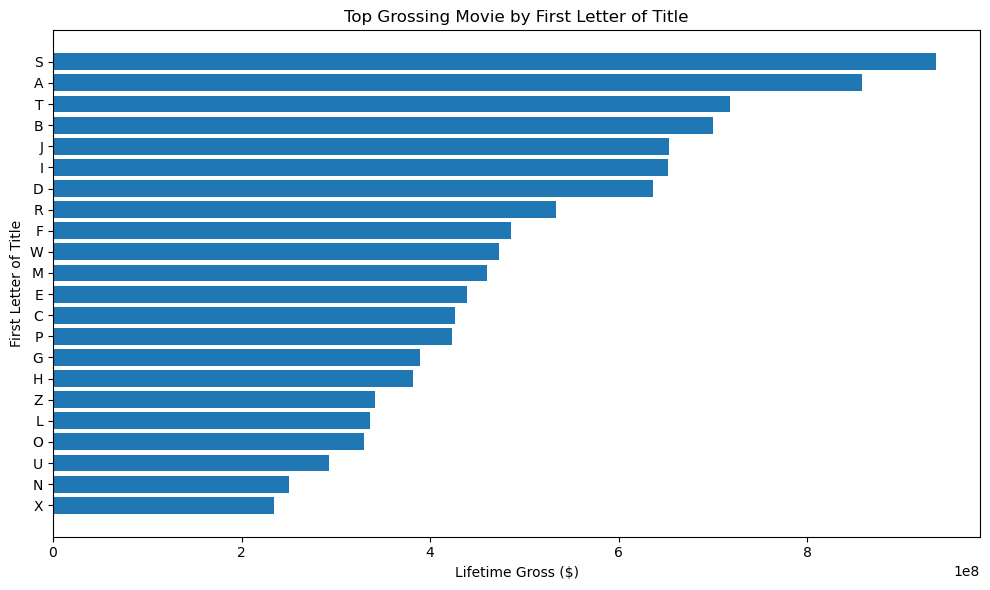

In [79]:
import string
results = []

for letter in string.ascii_uppercase:
    pipeline = [
        {"$match": {"title": {"$regex": f"^{letter}", "$options": "i"}}},
        {"$sort": {"lifetime_gross": -1}},
        {"$limit": 1}
    ]
    top_movie = list(collection.aggregate(pipeline))
    if top_movie:
        results.append({
            "letter": letter,
            "title": top_movie[0]["title"],
            "lifetime_gross": top_movie[0]["lifetime_gross"]
        })

df = pd.DataFrame(results).sort_values("lifetime_gross", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df["letter"], df["lifetime_gross"])
plt.title("Top Grossing Movie by First Letter of Title")
plt.xlabel("Lifetime Gross ($)")
plt.ylabel("First Letter of Title")
plt.tight_layout()
plt.show()

### Distribution of Lifetime Grosses

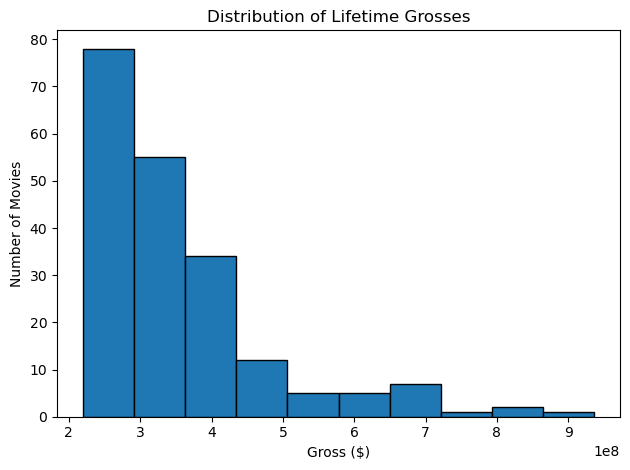

In [57]:
import matplotlib.pyplot as plt

cursor = collection.find({}, {"lifetime_gross": 1, "_id": 0})
grosses = [doc["lifetime_gross"] for doc in cursor]

plt.hist(grosses, bins=10, edgecolor='black')
plt.title("Distribution of Lifetime Grosses")
plt.xlabel("Gross ($)")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()